# Exploring triaxial orbit families with `Gala` and `superfreq`

*by Adrian Price-Whelan*

## Goals

* Learn to use the gravitational potential classes implemented in `gala`
* Learn to numerically integrate orbits using the integrators in `gala`
* Numerically estimate the fundamental frequencies of orbits using `superfreq`
* Visualize orbits that lie in different orbit families, as identified from frequency ratios
* Identify chaotic orbits by estimating the frequency drift

Note that this tutorial assumes that you are at least conceptually familiar with the concept of orbits, gravitational potentials, and orbital frequency analysis.

## Setup

This tutorial requires several Python packages that may not be installed in your Python environment by default. Several of these packages require using Python>=3.6, so also check your Python version. If you need to update your version of Python and you are *not* using the Anaconda package manager, you may want to consider [downloading and installing conda](http://anaconda.org/downloads). 

**If you are already using `conda`**, you can install the necessary packages with:

    conda install -c conda-forge numpy scipy matplotlib astropy cython astro-gala tqdm
    pip install superfreq
    
**If you use `pip`**, you can install the necessary packages with:
    
    pip install numpy scipy matplotlib cython
    pip install astropy astro-gala superfreq tqdm

In [81]:
# Package imports that we will need throughout this tutorial:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from scipy.optimize import fsolve
from tqdm import trange, tqdm
from IPython.display import Image

import gala.integrate as gi
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic

import superfreq as sf

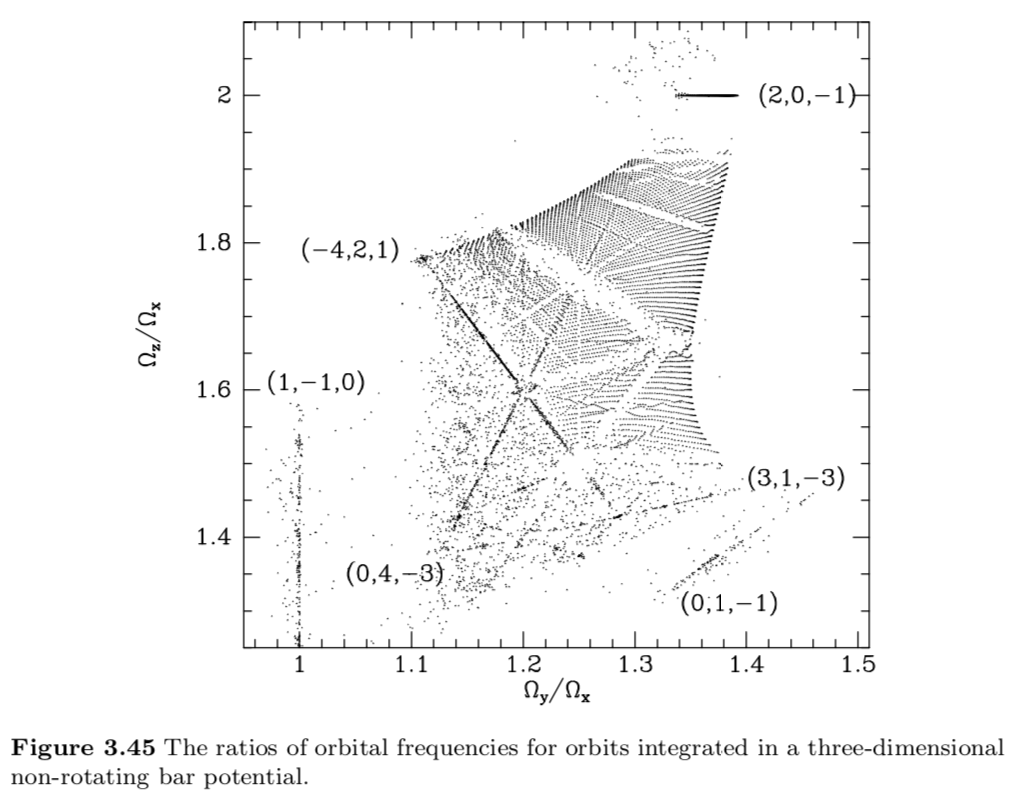

In [3]:
Image(filename='BTFig3.45.png', width=512) 

Our first goal for this tutorial is to reproduce something that looks like the above figure from Galactic Dynamics (pg. 260, Binney & Tremaine 2008; BT08). This figure shows fundamental frequency ratios computed from a bunch of orbits (each black point is an orbit) integrated in a particular gravitational potential, defined in equation 3.310:

$$
\Phi(\boldsymbol{x}) = \frac{1}{2} \, \ln \left[x^2 + (y/0.9)^2 + (z/0.7)^2 + 0.1\right]
$$

To produce this figure, we have to first set up a grid of orbital initial conditions similar to how it is done in BT08, then numerically integrate each orbit for some amount of time, and finally use the orbital trajectories to estimate the fundamental frequencies. 

### Defining the gravitational potential

Let's start by creating a Python object to represent the above graviational potential. Many common analytic potential models are implemented in `gala.potential` and make use of unit systems through the `astropy.units` framework. Here, however, the potential is dimensionless, so we will define the potential object using the numbers specified in Eq. 3.310 with no associated units. The potential specified above is a particular instance of a more general class of logarithmic potentials. These are often parametrized more generally as:

$$
\Phi(\boldsymbol{x}) = \frac{1}{2} \, v_c^2 \, \ln \left[(x/q_1)^2 + (y/q_2)^2 + (z/q_3)^2 + r_h^2\right]
$$

This general form is implemented in `gala` as the `gala.potential.LogarithmicPotential` class. Note that have imported `gala.potential` as `gp` above, so you will often see this shorthand below. By comparing the general form to Eq. 3.310, we can see that here we want: $v_c = 1$, $q_1 = 1$, $q_2 = 0.9$, $q_3 = 0.7$, and $r_h = \sqrt{0.1}$. Let's use these values to define the potential object:

In [4]:
pot = gp.LogarithmicPotential(v_c=1, r_h=np.sqrt(0.1), q1=1, q2=0.9, q3=0.7)

Each potential class or model that is implemented in `gala` has the same functionality that may help you with your work - see the [gala.potential documentation](http://gala.adrian.pw/en/latest/potential/index.html) for more details. Some important highlights:
* Each potential object has three core methods: `.energy()`, `.gradient()`, and `.density()`. `energy()` computes the potential energy at a specified location, `gradient()` computes the (Cartesian) gradient of the potential at a specified location, and `density()` compute the corresponding density of the mass distribution that generates the potential (for potentials with corresponding densities - not all potentials have well-defined density functions, such as the one we are using, the logarithmic potential). 
* Some other, potentially useful methods are `.mass_enclosed()` and `.circular_velocity()`, which return approximations to the enclosed mass and circular velocity at the specified location.
* There are also methods for plotting 2D projected isopotential and isodensity contours using the `.plot_contours()` and `.plot_density_contours()` methods, but we won't cover those today.

For example:

In [275]:
pot.gradient([1., 0.5, 0.1])

<Quantity [[0.69976551],
           [0.43195402],
           [0.14280929]]>

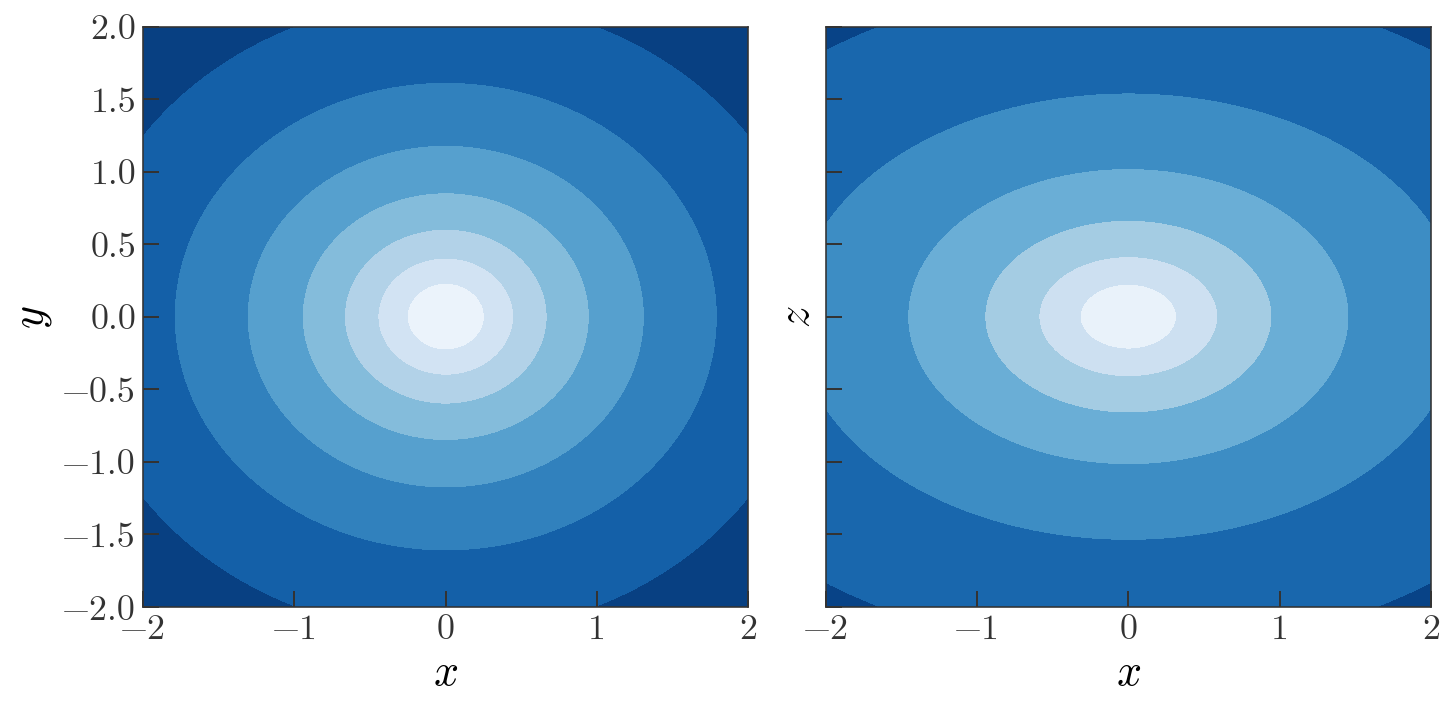

In [282]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                         sharex=True, sharey=True)

grid = np.linspace(-2, 2, 128)
_ = pot.plot_contours(grid=(grid, grid, 0), ax=axes[0])
_ = pot.plot_contours(grid=(grid, 0, grid), ax=axes[1])

axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
fig.tight_layout()

### Setting up the initial conditions

BT08 describes their method for creating initial conditions as: "10 000 orbits were obtained by dropping particles from a grid of points on the surface Φ(x) = 0.5". This doesn't tell use exactly how they generated their initial conditions, but from this explanation we do know that all of the orbits in their grid have zero kinetic energy and the same potential energy, $\phi(x) = 0.5$. We will generate a grid of initial conditions on one octant of the equipotential surface (since it is triaxial, it has 8-fold symmetry) using a modification of the [Fibonacci sphere algorithm](https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere). 

We will first use this method to generate a specified number of spherical angles, $\phi, \theta$. For now, we will compute ~2048 orbits because the full notebook runs in a few minutes with this number of orbits. But feel free to increase this (e.g., try 8192) for better resolution in some of the plots below.

In [206]:
n_orbits = 2048

num_pts = 8 * n_orbits
indices = np.arange(0, num_pts) + 0.5
theta = np.arccos(1 - 2*indices/num_pts)
phi = (np.pi * (1 + 5**0.5) * indices) % (2*np.pi)

angles = np.array([phi, theta]).T
angles = angles[(phi < np.pi/2) & (theta < np.pi/2)]
n_orbits = angles.shape[0]

We now need to compute the spherical radius for each set of angles that corresponds to the desired equipotential surface. We do this by specifying the potential value (BT08 uses $\Phi = 0.5$), and solving for the radius given all other quantities:

In [207]:
def get_xyz(r, phi, theta):
    x = r * np.cos(phi) * np.sin(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(theta)
    return [x, y, z]

def f1(p, phi, theta, pot_val):
    r, = p
    xyz = get_xyz(r, phi, theta)
    return pot.energy(xyz)[0] - pot_val

In [208]:
pot_val = 0.5

In [209]:
xyz = []
for phi, theta in tqdm(angles):
    r, = fsolve(f1, x0=[0.5], args=(phi, theta, pot_val))
    xyz.append(get_xyz(r, phi, theta))
xyz = np.array(xyz).T

100%|██████████| 2048/2048 [00:02<00:00, 902.05it/s]


Let's plot the initial conditions in 3D:

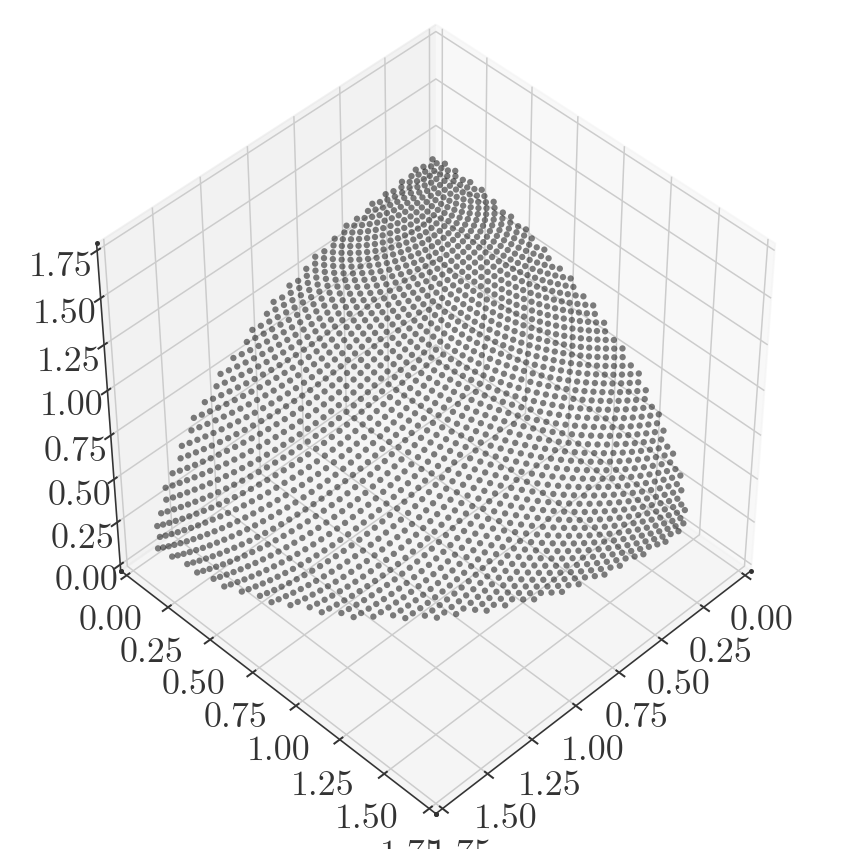

In [214]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[0], xyz[1], xyz[2], 
           s=10, linewidth=0, color='k', alpha=0.5)

ax.set_xlim(0, 1.75)
ax.set_ylim(0, 1.75)
ax.set_zlim(0, 1.75)

ax.elev = 45
ax.azim = 45

fig.tight_layout()

We now have our initial conditions: we will initialize a set of orbits from 1/8 of the equipotential surface starting with zero velocity. We have the positions of the initial conditions, so to define a set of initial conditions that `gala` can understand, we will create a `PhaseSpacePosition()` object by also passing in velocity information (here, all zeros):

In [260]:
w0 = gd.PhaseSpacePosition(pos=xyz, 
                           vel=np.zeros_like(xyz))

We are now set up to numerically integrate the initial conditions! To integrate orbits, we have to specify information about how long to integrate for. For example, we can either pass in a timestep `dt` and a number of steps to integrate for `n_steps`, or specify a timestep, beginning, and end time. Here, we will use a timestep and number of steps. In this case, these are chosen so that the typical orbit we integrate has about 40 steps per orbital period, and we integrate for a total of about 100 orbital periods. Note that here we use the  Dormand-Prince 8th order Runge Kutta integration scheme, but this can be swapped out for other integrators such as Leapfrog (e.g., here, pass in `Integrator=gi.LeapfrogIntegrator` instead):

In [352]:
orbits = pot.integrate_orbit(w0, dt=0.1, n_steps=4000, 
                             Integrator=gi.DOPRI853Integrator)

Let's now look at a Cartesian projection of a few random orbits:

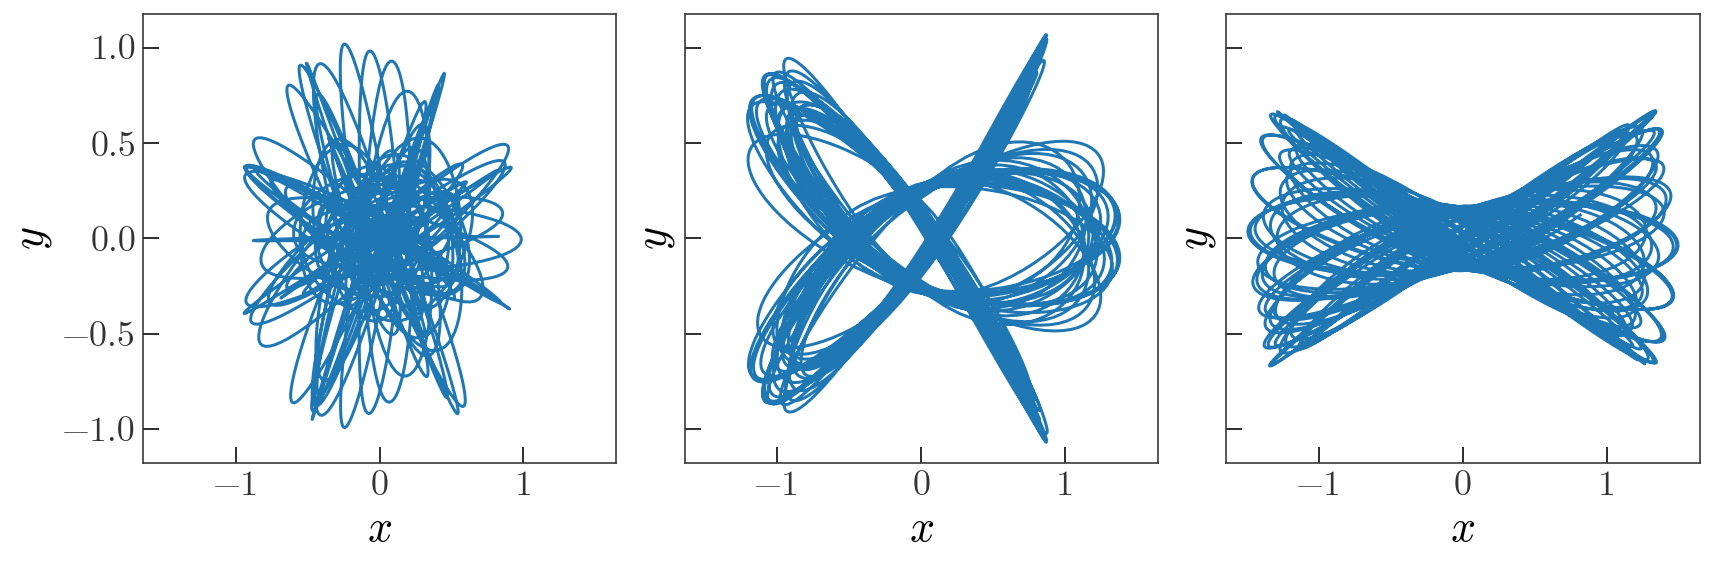

In [353]:
idx = [10, 813, 1026] # picked at random to show different types of orbits!

fig, axes = plt.subplots(1, 3, figsize=(12, 4), 
                         sharex=True, sharey=True)

for j, i in enumerate(idx):
    orbits[:, i].plot(['x', 'y'], axes=[axes[j]], autolim=False, auto_aspect=False)
    
fig.tight_layout()

These orbits look visually different: This is a manifestation of the fact that each of these orbits have different _fundamental frequencies_ and _orbital actions_ that associate them with different orbital families. If we want to see this more clearly, we would ideally like to map out the orbit space in action-space or frequency-space, however, in the gravitational potential we are using (and in general!), there is no analytic transformation from the cartesian orbits we have to actions/frequencies. Several numerical methods exist for approximating this transformation - I recommend reading [this review by Jason Sanders](https://ui.adsabs.harvard.edu/abs/2016MNRAS.457.2107S/abstract) and any citations within for more information.

Here, we will use one particular method for estimating the fundamental frequencies of an orbit by exploiting the fact that these fundamental frequencies will manifest themselves in the computed orbital time series we have in hand. For the three example orbits above, we therefore expect that the Fourier transform of the orbit time series should look qualitatively different - let's check!

Text(0.5, 0, 'frequency')

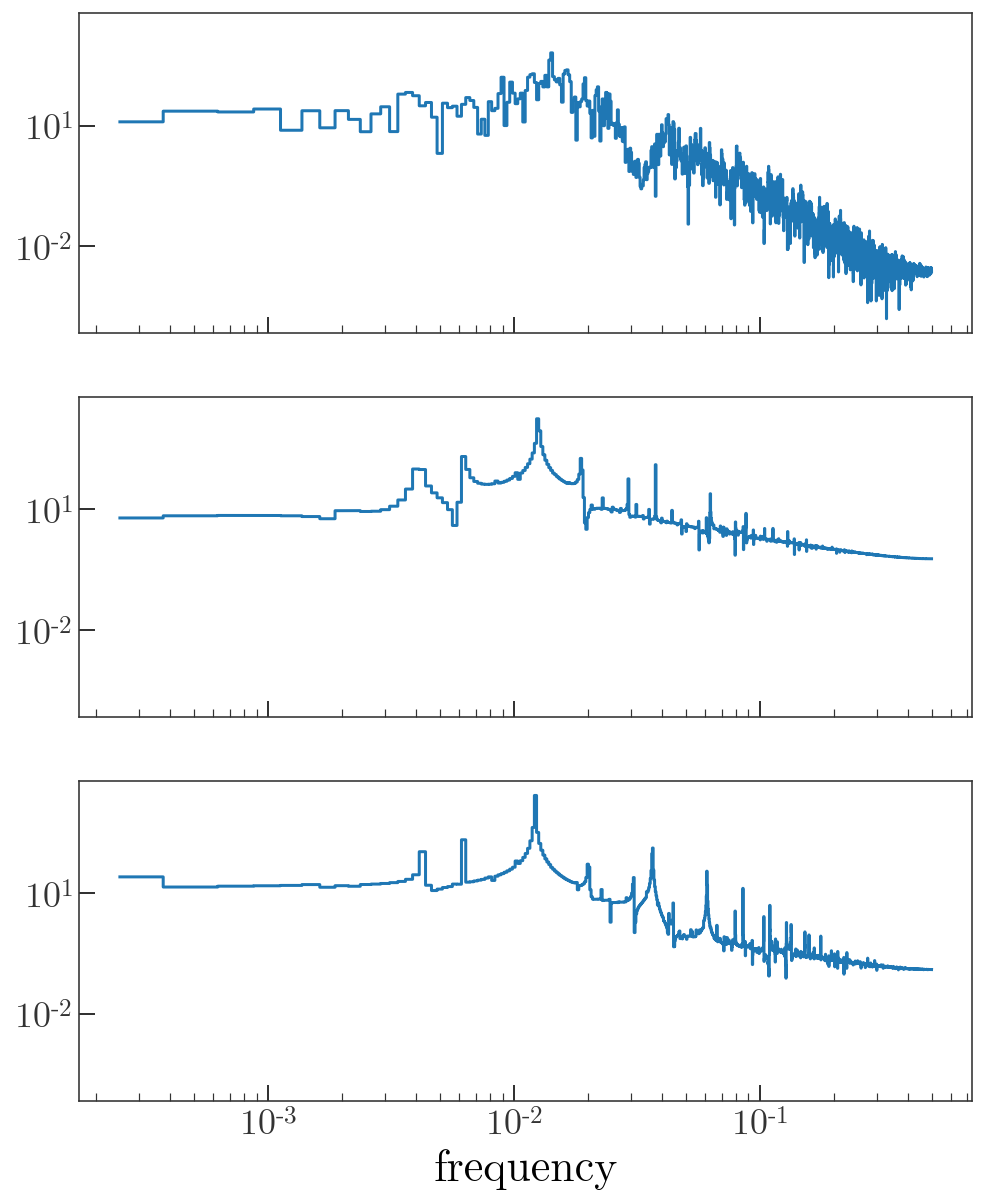

In [354]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True, sharey=True)

for j, i in enumerate(idx):    
    fft = np.fft.fft(orbits[:, i].x.value)
    freq = np.fft.fftfreq(orbits[:, i].x.shape[0])
    
    ax = axes[j]
    ax.plot(freq[freq > 0], np.abs(fft[freq > 0]), 
            marker='', drawstyle='steps-mid')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
ax.set_xlabel('frequency')

The first orbit visually appears to be chaotic or irregular, and this manifests in the frequency spectrum: the spectrum is noisy, and no dominant spectral features are prominent in the spectrum. The second orbit is a near-resonant regular orbit that does have several prominent features: the location of these spikes are linear, integer combinations of the fundamental frequencies! The third orbit also appears to be regular, and has several dominant frequencies that again represent combinations of the fundamental frequencies.

We will now use `superfreq` to compute the fundamental frequencies for each of the orbits we computed above. `superfreq` is an implementation of the NAFF frequency finding method; originally proposed by [J. Laskar](https://ui.adsabs.harvard.edu/abs/1993PhyD...67..257L/abstract), [this paper by Monica Valluri](https://ui.adsabs.harvard.edu/abs/1998ApJ...506..686V/abstract) has a nice description of the method and application to galactic dynamics. The general idea of the method is to (1) fourier transform combinations of orbital time series, (2) identify significant spectral features, (3) solve for a set of 3 unique frequencies that can produce all features - these are the fundamental frequencies. 

To use `superfreq`, we first have to create an instance of the `SuperFreq()` class by passing in the time information for the orbits we are going to analyze:

In [355]:
superfreq = sf.SuperFreq(t=orbits.t.value)

We can now loop over all of the orbits we have and solve for their fundamental frequencies. You will notice in the below that, rather than pass in just positional information, we pass in complex combinations of position and velocity - this allows us to make use of all of the phase-space dimensions to produce the best estimates of the frequency spectra:

In [356]:
all_freqs = []
n_fail = 0
for j in trange(n_orbits):
    fs = [orbits[:, j].xyz[i] + 1j*orbits[:, j].v_xyz[i] 
          for i in range(3)]
    try:
        freqs, *_ = superfreq.find_fundamental_frequencies(fs)
    except (RuntimeError, IndexError):
        freqs = np.full(3, np.nan)
        n_fail += 1
    all_freqs.append(freqs)
all_freqs = np.array(all_freqs)

print("{} failed".format(n_fail))

100%|██████████| 2048/2048 [03:49<00:00,  8.93it/s]

0 failed


We now have computed numerical estimates of the three fundamental frequencies for all of the orbits in our grid. Let's reproduce Figure 3.45! To do this, we plot the frequency ratios:

Text(0, 0.5, '$\\Omega_z / \\Omega_x$')

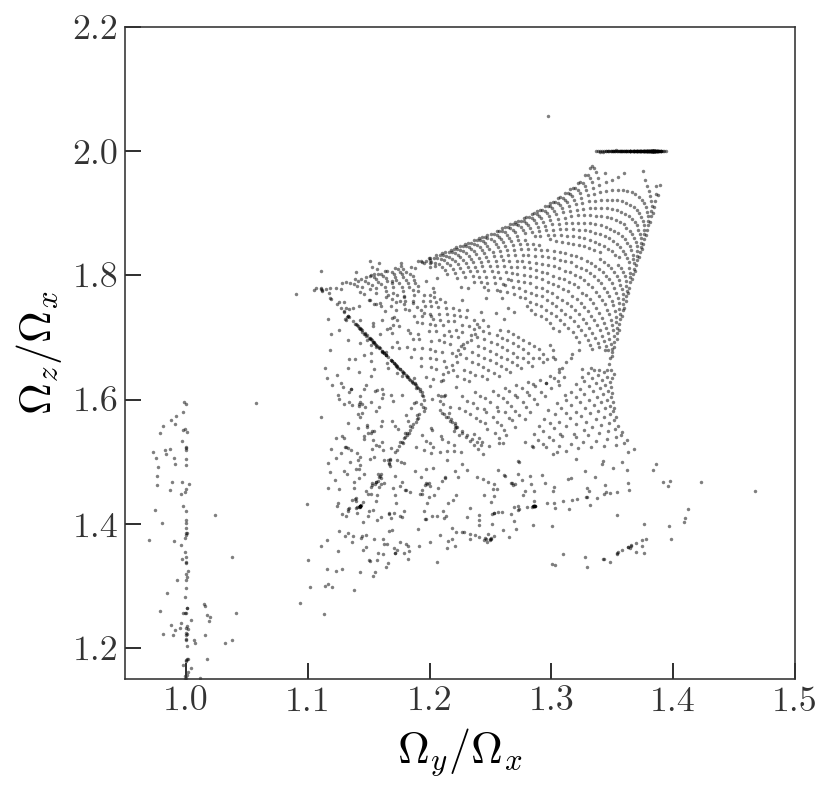

In [357]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

fratio_yx = all_freqs[:, 1] / all_freqs[:, 0]
fratio_zx = all_freqs[:, 2] / all_freqs[:, 0]

ax.scatter(fratio_yx, fratio_zx,
           marker='o', s=3., color='k', alpha=0.5, lw=0)

ax.set_xlim(0.95, 1.5)
ax.set_ylim(1.15, 2.2)

ax.set_xlabel(r'$\Omega_y / \Omega_x$')
ax.set_ylabel(r'$\Omega_z / \Omega_x$')

Indeed, this looks like a sparser version of the same plot in BT08 (they used 10000 orbits, we only have ~2000 here)! Note that, like in BT08, the regular grid manifests primarily in the upper right corner of the frequency ratio plot, whereas the frequencies in the lower right corner tend to be more randomly distributed. The upper right corner of this plot is dominated by regular orbits, whereas the lower left corner is dominated by chaotic orbits. Chaotic orbits do not have truely fundamental frequencies--their frequencies evolve erratically with time, erasing the orderly grid-like structure of our initial conditions. Note also the linear under- and over-densities in this figure that mark the location of resonances. Let's select a few orbits from this plot and plot their orbits to see how resonant and chaotic orbits look in real-space.

In [416]:
resonant_mask1 = np.where((fratio_yx > 1.3) & (fratio_yx < 1.4) &
                          (fratio_zx > 1.98) & (fratio_zx < 2.02))[0]

resonant_mask2 = np.where((fratio_yx > 1.17) & (fratio_yx < 1.18) &
                          (fratio_zx > 1.52) & (fratio_zx < 1.55))[0]

chaotic_mask = np.where((fratio_yx > 1.15) & (fratio_yx < 1.2) &
                        (fratio_zx > 1.2) & (fratio_zx < 1.4))[0]

Let's plot the orbits we selected:

Text(0, 0.5, '$\\Omega_z / \\Omega_x$')

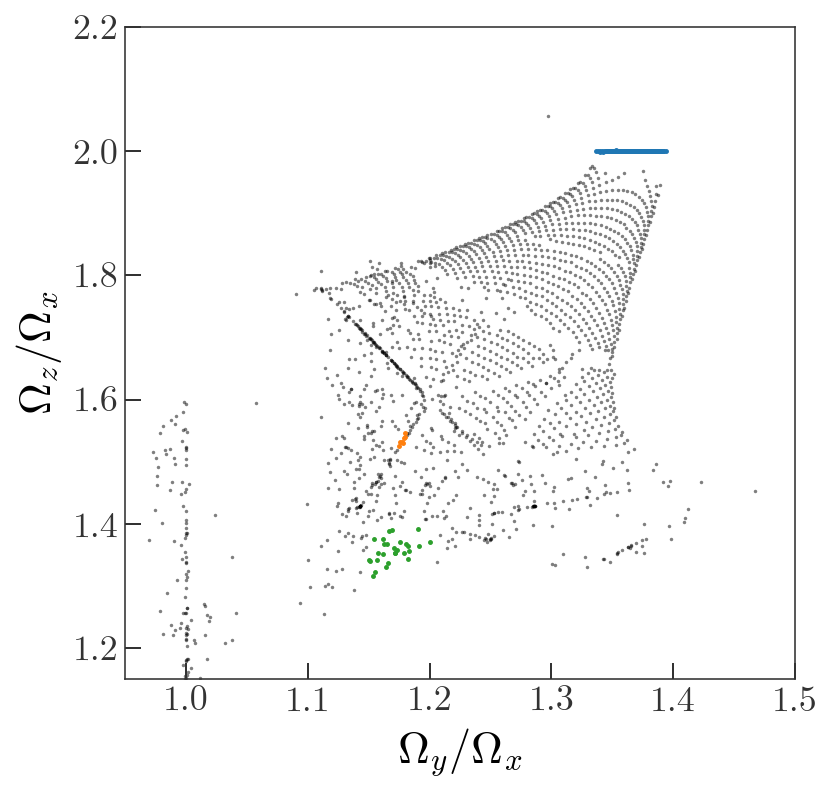

In [417]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(fratio_yx, fratio_zx,
           marker='o', s=3., color='k', alpha=0.5, lw=0)

for mask in [resonant_mask1, resonant_mask2, chaotic_mask]:
    ax.scatter(fratio_yx[mask], fratio_zx[mask],
               marker='o', s=6., alpha=1, lw=0)

ax.set_xlim(0.95, 1.5)
ax.set_ylim(1.15, 2.2)

ax.set_xlabel(r'$\Omega_y / \Omega_x$')
ax.set_ylabel(r'$\Omega_z / \Omega_x$')

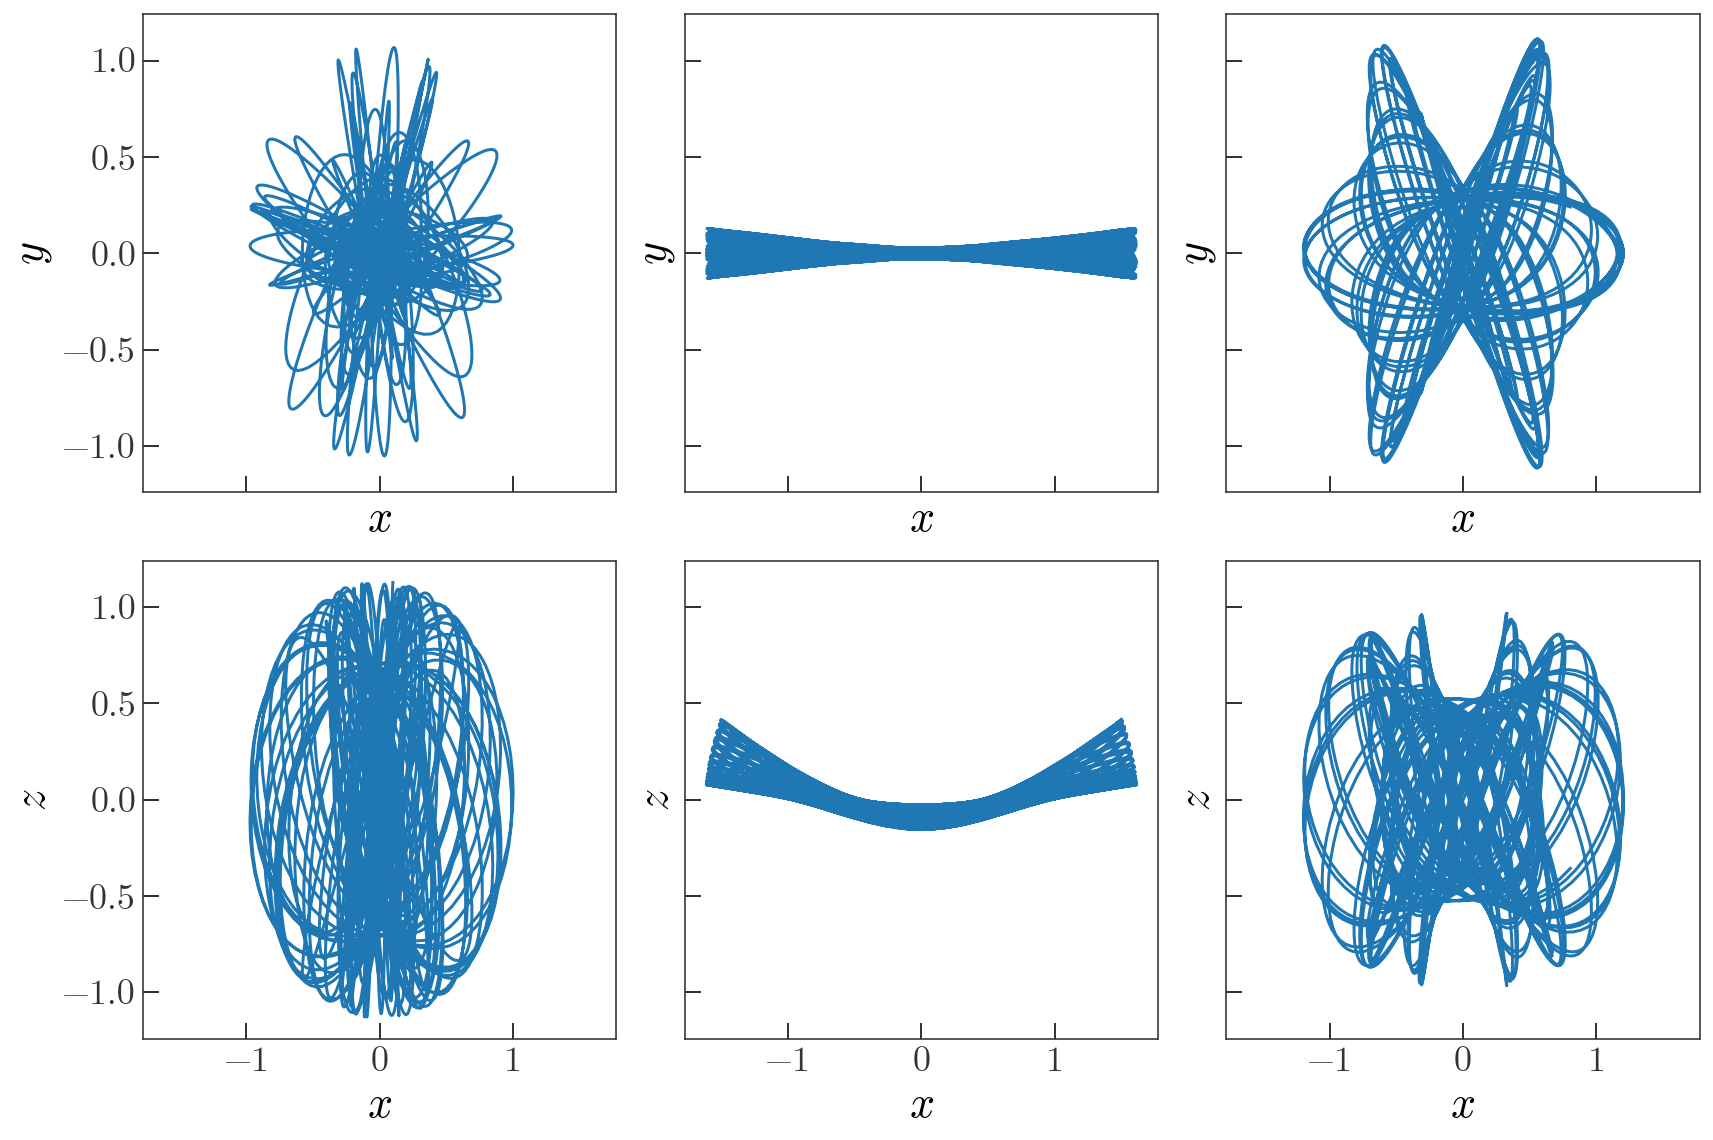

In [418]:
idx = [chaotic_mask[0], 
       resonant_mask1[0], 
       resonant_mask2[0]]

fig, axes = plt.subplots(2, 3, figsize=(12, 8), 
                         sharex=True, sharey=True)

for j, i in enumerate(idx):
    orbits[:, i].plot(['x', 'y'], axes=[axes[0, j]], autolim=False, auto_aspect=False)
    orbits[:, i].plot(['x', 'z'], axes=[axes[1, j]], autolim=False, auto_aspect=False)
    
fig.tight_layout()

The right two columns above show regular orbits near two resonances in this gravitational potential, whereas the left orbit is clearly chaotic (its appearance is more erratic than the other two). As mentioned before, this is because chaotic orbits do not actually have fundamental (invariant) frequencies! Frequency analysis therefore provides a sensitive way of identifying chaotic orbits, and assessing the strength of chaos for a given orbit. To identify chaotic orbits, we can assess the _frequency drift_ of an orbit: Numerically estimate the fundamental frequencies from two, subsequent segments of an integrated orbit and difference the frequency values. Let's try this for the three orbits we identified above. We will re-integrate these three orbits for a longer amount of time so we can split the orbits into two segments.

In [425]:
freq_diffs = []
for j, i in enumerate(idx):
    long_orbit = pot.integrate_orbit(w0[i], dt=0.1, n_steps=8000, 
                                     Integrator=gi.DOPRI853Integrator)
    
    orbit1 = long_orbit[:4000]
    orbit2 = long_orbit[4000:]

    fs1 = [orbit1.xyz[i] + 1j*orbit1.v_xyz[i] 
           for i in range(3)]
    fs2 = [orbit2.xyz[i] + 1j*orbit2.v_xyz[i] 
           for i in range(3)]
    
    freqs1, *_ = sf.SuperFreq(t=orbit1.t.value).find_fundamental_frequencies(fs1)
    freqs2, *_ = sf.SuperFreq(t=orbit2.t.value).find_fundamental_frequencies(fs2)
    
    freq_diffs.append(freqs2 - freqs1)
    
freq_diffs = np.array(freq_diffs)

In [428]:
np.linalg.norm(freq_diffs, axis=1)

array([3.62564131e-02, 4.34988026e-06, 1.49282985e-04])

In order, these are the frequency differences for the chaotic orbit, near-resonant orbit 1, and near-resonant orbit 2. The chaotic orbit has the largest frequency drift, whereas the near-resonant orbit 1 difference may just be due to numerical precision. The drify for the second regular orbit indicates that it may in fact be weakly chaotic instead.